In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from scipy import ndimage
from scipy import linalg
from skimage.util.shape import view_as_windows
import random
import math
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage import io
import radiomics
from enum import Enum
from radiomics.glcm import RadiomicsGLCM
import SimpleITK as sitk
import imageio
from itertools import product
import mahotas as mt
from eolearn.features.haralick import HaralickTask
from eolearn.core import EOPatch
from skimage.feature.texture import greycomatrix

In [2]:
# Read sample data.
img_s = sitk.ReadImage('../sample_data/ImageSlice.png')
mask_s = sitk.ReadImage('../sample_data/ImageMask.png')

In [3]:
# Turn image into a Numpy array.
img_array = sitk.GetArrayFromImage(img_s)
img_array = img_array[:,:,0]
print(f'IMAGE:\nwidth={img_array.shape[0]} height={img_array.shape[1]}')

IMAGE:
width=440 height=596


In [4]:
# Create random window.
patch_window_width = 47
patch_window_height = 41
svd_window_size = 5
haralick_window_size = svd_window_size * 2 + 1
mask_min_x = 252
mask_max_x = 298
mask_min_y = 193
mask_max_y = 233

In [5]:
def show_colored_image(figure, axis, image_data, colormap=plt.cm.jet):
    image = axis.imshow(image_data, cmap=colormap)
    divider = make_axes_locatable(axis)
    colorbar_axis = divider.append_axes("right", size="5%", pad=0.05)
    figure.colorbar(image, cax=colorbar_axis)

def create_highlighted_rectangle(x, y, w, h):
    return Rectangle((x, y), w, h, linewidth=3, edgecolor='cyan', facecolor='none')

def highlight_rectangle_on_image(image_data, min_x, min_y, w, h, colormap=plt.cm.gray):
    figure, axes = plt.subplots(1,2, figsize=(15,15))

    # Highlight window within image.
    show_colored_image(figure, axes[0], image_data, colormap)
    axes[0].add_patch(create_highlighted_rectangle(min_x, min_y, w, h))

    # Crop window.
    cropped_array = image_data[min_y:min_y+h, min_x:min_x+w]
    axes[1].set_title(f'Cropped Region ({w}x{h})')
    show_colored_image(figure, axes[1], cropped_array, colormap)
    
    plt.show()
    
    return cropped_array

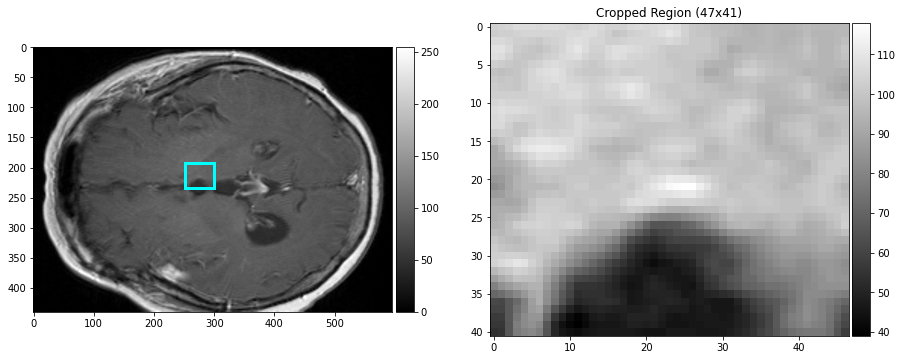

In [6]:
cropped_array = highlight_rectangle_on_image(img_array, mask_min_x, mask_min_y, patch_window_width, patch_window_height)

In [7]:
cropped_padded_array = img_array[mask_min_x - int(svd_window_size / 2):mask_min_x + patch_window_width + int(svd_window_size / 2), mask_min_y - int(svd_window_size / 2):mask_min_y + patch_window_height + int(svd_window_size / 2)]

Text(0.5, 1.0, 'dy size=(41, 47)')

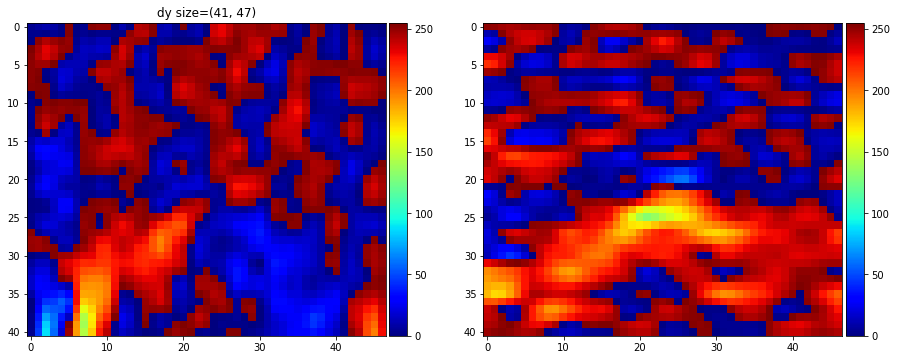

In [8]:
figure, axes = plt.subplots(1, 2, figsize=(15, 15))

# Define kernel for x differences.
kernel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])

# Define kernel for y differences.
kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# Perform x convolution.
dx=ndimage.convolve(cropped_array, kernel_x)

# Perform y convolution.
dy=ndimage.convolve(cropped_array, kernel_y)

# Display dx & dy.
show_colored_image(figure, axes[0], dx)
axes[0].set_title(f'dx size={dx.shape}')
show_colored_image(figure, axes[1], dy)
axes[0].set_title(f'dy size={dy.shape}')

Creating windows:
Creating windows done.
Center x,y = 34, 16
dx Patch for SVD:


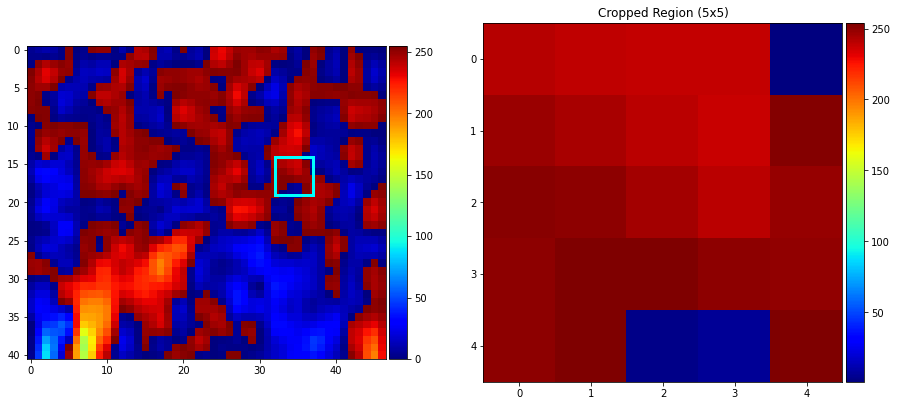

dy Patch for SVD:


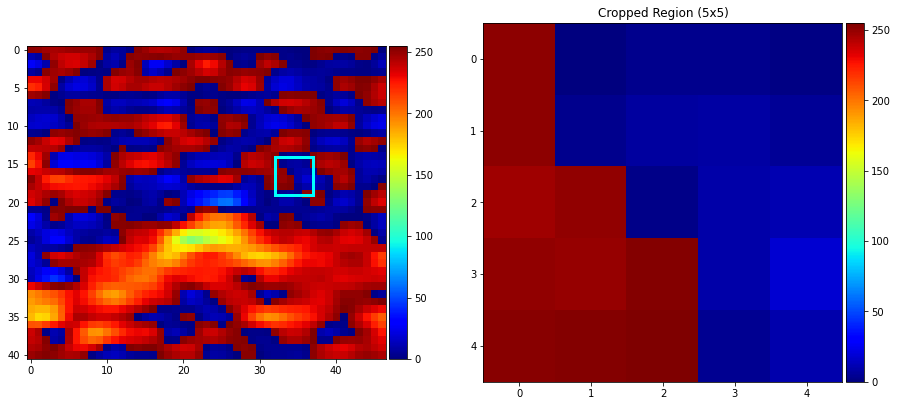

In [9]:
# Create windows.
print('Creating windows:')
dx_windows = view_as_windows(dx, (svd_window_size, svd_window_size))
dy_windows = view_as_windows(dy, (svd_window_size, svd_window_size))
print('Creating windows done.')

# Extract a random patch
svd_center_x = random.randint(int(svd_window_size/2),dx_windows.shape[1]-int(svd_window_size/2))
svd_center_y = random.randint(int(svd_window_size/2),dx_windows.shape[1]-int(svd_window_size/2))

print(f'Center x,y = {svd_center_x}, {svd_center_y}')

# Get window at x,y.
dx_patch = dx_windows[svd_center_y, svd_center_x]
dy_patch = dy_windows[svd_center_y, svd_center_x]

# Display windows.
svd_min_x = svd_center_x - int(svd_window_size/2)
svd_min_y = svd_center_y - int(svd_window_size/2)
print('dx Patch for SVD:')
highlight_rectangle_on_image(dx, svd_min_x, svd_min_y, svd_window_size, svd_window_size, plt.cm.jet)
print('dy Patch for SVD:')
highlight_rectangle_on_image(dy, svd_min_x, svd_min_y, svd_window_size, svd_window_size, plt.cm.jet)
print('')

In [10]:
def svd_dominant_angle(center_x, center_y, dx_windows, dy_windows, window_size):
   dx_patch = dx_windows[center_y-int(window_size/2), center_x-int(window_size/2)]
   dy_patch = dy_windows[center_y-int(window_size/2), center_x-int(window_size/2)]
   window_area = window_size * window_size
   flattened_gradients = np.zeros((window_area, 2))
   #print(f'Flattened gradients shape = {flattened_gradients.shape}')
   flattened_gradients[:,0] = np.reshape(dx_patch, ((window_area)))
   flattened_gradients[:,1] = np.reshape(dy_patch, ((window_area)))
   #print('Calculating svd...', flush=True)
   U, S, V = linalg.svd(flattened_gradients)
   #print('Calculating svd done.', flush=True)
   #print(f'V (from SVD) = \\n{V}')
   dominant_angle = math.atan2(V[0, 0], V[0, 1])
   #print(f'Dominant angle = atan2({V[0, 0]}/{V[0, 1]})={dominant_angle}')
   return dominant_angle

Calculating svd:
Calculating svd done.


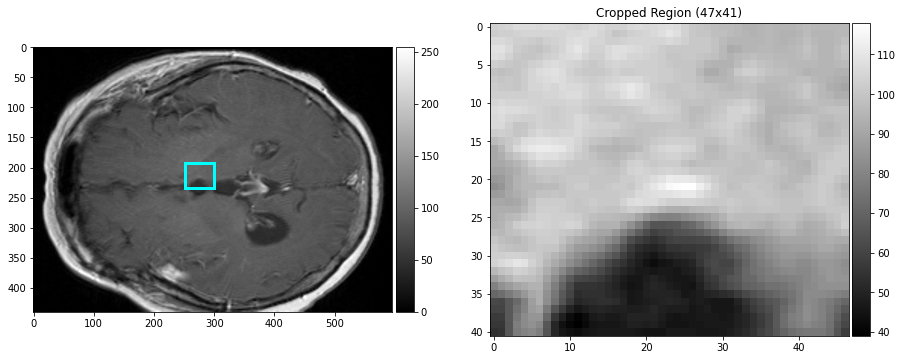

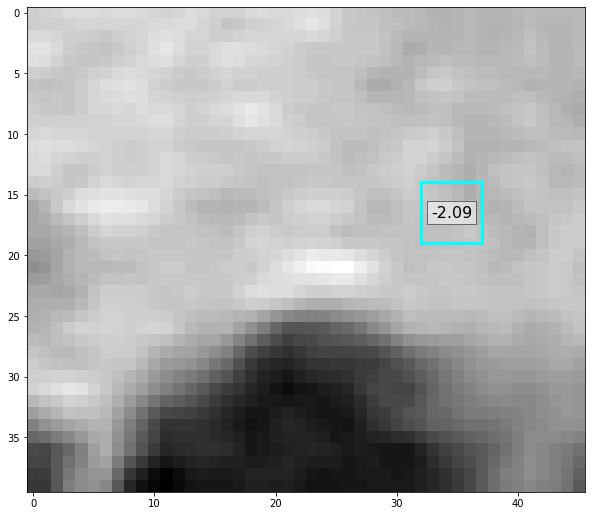

In [11]:
print('Calculating svd:')
dominant_angle = svd_dominant_angle(svd_center_x, svd_center_y, dx_windows, dy_windows, svd_window_size)
print('Calculating svd done.')

# Show highlighted region.
highlight_rectangle_on_image(img_array, mask_min_x, mask_min_y, patch_window_width, patch_window_height)

# Overlay dominant angle on top of window.
figure, axis = plt.subplots(1, 1, figsize=(10, 10))
image_patch_array = img_array[mask_min_y:mask_max_y, mask_min_x:mask_max_x]
axis.imshow(image_patch_array, cmap=plt.cm.gray)
axis.add_patch(create_highlighted_rectangle(svd_min_x, svd_min_y, svd_window_size, svd_window_size))
axis.text(svd_min_x + svd_window_size / 2, svd_min_y + svd_window_size / 2, round(dominant_angle, 2), fontsize=16, horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

In [12]:
def arrow_for_window(window_array, center_x, center_y, window_size, dominant_angle):
    arrow_dx = math.cos(dominant_angle) * window_size / 1.1
    arrow_dy = math.sin(dominant_angle) * window_size / 1.1 * -1
    arrow_x = center_x
    arrow_y = center_y
#     print(f'x={arrow_x} y={arrow_y} dx={arrow_dx} dy={arrow_dy}')
    return mpatches.Arrow(arrow_x, arrow_y, arrow_dx, arrow_dy, width=window_size / 2, color='orange')

In [13]:
def show_arrow_on_window(window_array, center_x, center_y, window_size, dominant_angle):
    fig, ax = plt.subplots(1)
    ax.imshow(window_array, cmap=plt.cm.gray)
    ax.add_patch(arrow_for_window(window_array, center_x, center_y, window_size, dominant_angle))
    plt.show()

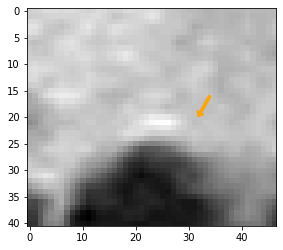

In [14]:
show_arrow_on_window(cropped_array, svd_center_x, svd_center_y, svd_window_size, dominant_angle)

IndexError: index 40 is out of bounds for axis 0 with size 37

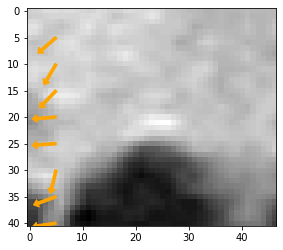

In [15]:
fig, ax = plt.subplots(1)
ax.imshow(cropped_array, cmap=plt.cm.gray)
half_window = int(svd_window_size / 2)
for x in range(0, dx_windows.shape[0] - half_window, svd_window_size):
    for y in range(0, dy_windows.shape[1] - half_window, svd_window_size):
        dominant_angle = svd_dominant_angle(x + half_window, y + half_window, dx_windows, dy_windows, svd_window_size)
        ax.add_patch(arrow_for_window(cropped_array, x + svd_window_size, y + svd_window_size, svd_window_size, dominant_angle))
plt.show()

In [ ]:
# loop through all regions and calculate dominant angles
print('Calculating dominant angles:')
dominant_angles_array = np.zeros_like(cropped_array, np.single)
print(f'dx shape = {dx.shape}')
print(f'dominant angles shape = {dominant_angles_array.shape}')
print(f'svd window size = {svd_window_size}')
center_x_range = range(int(svd_window_size/2), dx.shape[1]-1-int(svd_window_size/2))
center_y_range = range(int(svd_window_size/2), dx.shape[0]-1-int(svd_window_size/2))
print(f'{center_x_range}, {center_y_range}')
for current_svd_center_x in center_x_range:
    for current_svd_center_y in center_y_range:
        current_dominant_angle = svd_dominant_angle(
            current_svd_center_x, current_svd_center_y,
            dx_windows, dy_windows, svd_window_size)
        dominant_angles_array[current_svd_center_y, current_svd_center_x] = current_dominant_angle
        if (random.randint(0,500)==0):
            print(f'x={current_svd_center_x}, y={current_svd_center_y}')
            print(f'angle={current_dominant_angle}')
print('Done calculating dominant angles.')

In [ ]:
figure, axis = plt.subplots(1, 1, figsize=(5,5))
show_colored_image(figure, axis, dominant_angles_array, plt.cm.jet)
axis.add_patch(create_highlighted_rectangle(svd_window_size, svd_window_size, svd_window_size, svd_window_size))
# print(dominant_angles_array[svd_window_size:svd_window_size*2,svd_window_size:svd_window_size*2])
highlight_rectangle_on_image(img_array, mask_min_x, mask_min_y, patch_window_width, patch_window_height)
print('')

In [ ]:
har_test = np.zeros(400)
for x in range(1, 401):
    har_test[x-1] = x
har_max = har_test.max()
har_min = har_test.min()
new_max = 63
new_min = 0
har_test = (har_test - har_min) / (har_max - har_min)
har_test = har_test * (new_max - new_min) + new_min
har_test = np.round(har_test)
har_test = np.reshape(har_test, (20, 20))
# haralick_image = np.zeros(har_test.shape, dtype=int)
har_test = har_test.astype(int)
print(har_test)
figure, axis = plt.subplots(1,1, figsize=(5,5))
show_colored_image(figure, axis, har_test)

In [ ]:
# def get_haralick_mt_value(img_array, center_x, center_y, window_size, haralick_feature, direction):
#     min_x = int(max(0, center_x - window_size / 2))
#     min_y = int(max(0, center_y - window_size / 2))
#     max_x = int(min(img_array.shape[1] - 1, center_x + window_size / 2))
#     max_y = int(min(img_array.shape[0] - 1, center_y + window_size / 2))
#     cropped_img_array = img_array[min_y:max_y, min_x:max_x]
# #     cmat = np.empty((64, 64), np.int32)
# #     def all_cmatrices():
# #         for dir in range(4):
# #             mt.features.texture.cooccurence(cropped_img_array, dir, cmat, symmetric=False)
# #             yield cmat
#     har_feature = mt.features.texture.haralick(img_array)
#     return har_feature[direction, haralick_feature]

In [ ]:
# def get_haralick_mt_value(img_array, center_x, center_y, window_size, haralick_feature, direction):
#     min_x = int(max(0, center_x - window_size / 2))
#     min_y = int(max(0, center_y - window_size / 2))
#     max_x = int(min(img_array.shape[1] - 1, center_x + window_size / 2))
#     max_y = int(min(img_array.shape[0] - 1, center_y + window_size / 2))
#     cropped_img_array = img_array[min_y:max_y, min_x:max_x]
#     har_feature = mt.features.texture.haralick(cropped_img_array, return_mean=True)
#     return har_feature[haralick_feature]

In [ ]:
# def get_haralick_mt_value(img_array, center_x, center_y, window_size, haralick_feature, direction):
#     min_x = int(max(0, center_x - window_size / 2))
#     min_y = int(max(0, center_y - window_size / 2))
#     max_x = int(min(img_array.shape[1] - 1, center_x + window_size / 2))
#     max_y = int(min(img_array.shape[0] - 1, center_y + window_size / 2))
#     cropped_img_array = img_array[min_y:max_y, min_x:max_x]
#     cmat = np.empty((64, 64), np.int32)
#     def all_cmatrices():
#         for dir in range(4):
#             mt.features.texture.cooccurence(cropped_img_array, dir, cmat, symmetric=False)
#             yield cmat
#     har_feature = mt.features.texture.haralick_features(all_cmatrices())
#     return har_feature[direction, haralick_feature]

In [ ]:
def get_haralick_mt_value(img_array, center_x, center_y, window_size, haralick_feature, direction, symmetric, mean):
    min_x = int(max(0, center_x - window_size / 2))
    min_y = int(max(0, center_y - window_size / 2))
    max_x = int(min(img_array.shape[1] - 1, center_x + window_size / 2))
    max_y = int(min(img_array.shape[0] - 1, center_y + window_size / 2))
    cropped_img_array = img_array[min_y:max_y, min_x:max_x]
    cmat = np.empty((64, 64), np.int32)
    def all_cmatrices():
        for dir in range(4):
            mt.features.texture.cooccurence(cropped_img_array, dir, cmat, symmetric=symmetric)
            yield cmat
    har_feature = mt.features.texture.haralick_features(all_cmatrices(), return_mean=mean)
    if mean:
        return har_feature[haralick_feature]
    return har_feature[direction, haralick_feature]

In [ ]:
def get_haralick_mt_feature(img, desired_haralick_feature, direction, haralick_window_size, symmetric=False, mean=False):
    haralick_image = np.zeros(img.shape)
    h, w = img.shape
    for pos in product(range(w), range(h)):
       result = get_haralick_mt_value(img, pos[0], pos[1], haralick_window_size, desired_haralick_feature, direction, symmetric, mean)
       haralick_image[pos[1], pos[0]] = result
    return haralick_image

In [ ]:
cropped_array_max = cropped_array.max()
cropped_array_min = cropped_array.min()
new_max = 63
new_min = 0
cropped_array_shaped = (cropped_array - cropped_array_min) / (cropped_array_max - cropped_array_min)
cropped_array_shaped = cropped_array_shaped * (new_max - new_min) + new_min
cropped_array_shaped = np.round(cropped_array_shaped)
cropped_array_shaped = cropped_array_shaped.astype(int)
figure, axis = plt.subplots(1,1, figsize=(5,5))
show_colored_image(figure, axis, cropped_array_shaped)
direction = 0

In [ ]:
plt.rc('figure', max_open_warning = 0)
for feature in range(13):
#     for direction in range(4):
        result = get_haralick_mt_feature(cropped_array_shaped, feature, direction, 20, symmetric=False, mean=True)
        figure, axis = plt.subplots(1,1, figsize=(5,5))
        show_colored_image(figure, axis, result)
        axis.set_title(f'Feature {feature+1} Mean')

In [ ]:
plt.rc('figure', max_open_warning = 0)
for feature in range(13):
    for direction in range(4):
        result = get_haralick_mt_feature(cropped_array_shaped, feature, direction, haralick_window_size, symmetric=True, mean=True)
        figure, axis = plt.subplots(1,1, figsize=(5,5))
        show_colored_image(figure, axis, result)
        axis.set_title(f'Symmetric Feature {feature+1} Mean')

In [ ]:
plt.rc('figure', max_open_warning = 0)
for feature in range(13):
    for direction in range(4):
        result = get_haralick_mt_feature(cropped_array_shaped, feature, direction, haralick_window_size, symmetric=True, mean=False)
        figure, axis = plt.subplots(1,1, figsize=(5,5))
        show_colored_image(figure, axis, result)
        axis.set_title(f'Symmetric Feature {feature+1} Direction {direction}')

In [ ]:
plt.rc('figure', max_open_warning = 0)
for feature in range(13):
    for direction in range(4):
        result = get_haralick_mt_feature(cropped_array_shaped, feature, direction, haralick_window_size, symmetric=False, mean=False)
        figure, axis = plt.subplots(1,1, figsize=(5,5))
        show_colored_image(figure, axis, result)
        axis.set_title(f'Feature {feature+1} Direction {direction}')

In [ ]:
for feature in range(13):
        result = get_haralick_mt_feature(har_test, feature, direction, 20, symmetric=False, mean=True)
        figure, axis = plt.subplots(1,1, figsize=(5,5))
        show_colored_image(figure, axis, result)
        axis.set_title(f'Feature {feature+1} Mean')

In [ ]:
for feature in range(13):
        result = get_haralick_mt_feature(har_test, feature, direction, 20, symmetric=True, mean=True)
        figure, axis = plt.subplots(1,1, figsize=(5,5))
        show_colored_image(figure, axis, result)
        axis.set_title(f'Symmetric Feature {feature+1} Mean')

In [ ]:
for feature in range(13):
    for direction in range(4):
        result = get_haralick_mt_feature(har_test, feature, direction, 20, symmetric=False, mean=False)
        figure, axis = plt.subplots(1,1, figsize=(5,5))
        show_colored_image(figure, axis, result)
        axis.set_title(f'Feature {feature+1} Direction {direction}')

In [ ]:
for feature in range(13):
    for direction in range(4):
        result = get_haralick_mt_feature(har_test, feature, direction, 20, symmetric=True, mean=False)
        figure, axis = plt.subplots(1,1, figsize=(5,5))
        show_colored_image(figure, axis, result)
        axis.set_title(f'Symmetric Feature {feature+1} Direction {direction}')

In [ ]:
def get_haralick_pyradiomics_value(img_array, center_x, center_y, window_size, haralick_feature):
    sitk_image = sitk.GetImageFromArray(img_array)
    haralick_mask = np.full(img_array.shape, 0)
    min_x = int(max(0, center_x - window_size / 2))
    min_y = int(max(0, center_y - window_size / 2))
    max_x = int(min(img_array.shape[1] - 1, center_x + window_size / 2))
    max_y = int(min(img_array.shape[0] - 1, center_y + window_size / 2))
    print(f'{min_x}, {min_y}, {max_x}, {max_y}')
    haralick_mask[min_y:max_y, min_x:max_x] = 1
    sitk_mask = sitk.GetImageFromArray(haralick_mask)
    haralick = RadiomicsGLCM(sitk_image, sitk_mask)
    haralick.enableFeatureByName(haralick_feature.value[0])
    haralick.execute()
    return haralick_feature.value[1](haralick)[0]

In [ ]:
# class HaralickFeature(Enum):
#     JointEntropy = ('JointEntropy', RadiomicsGLCM.getJointEntropyFeatureValue)
#     JointEnergy = ('JointEnergy', RadiomicsGLCM.getJointEnergyFeatureValue)
#     SumSquares = ('SumSquares', RadiomicsGLCM.getSumSquaresFeatureValue)
#     Idm = ('Idm', RadiomicsGLCM.getIdmFeatureValue)
#     Correlation = ('Correlation', RadiomicsGLCM.getCorrelationFeatureValue)
#     Imc1 = ('Imc1', RadiomicsGLCM.getImc1FeatureValue)
#     Imc2 = ('Imc2', RadiomicsGLCM.getImc2FeatureValue)
#     SumAverage = ('SumAverage', RadiomicsGLCM.getSumAverageFeatureValue)
#     ClusterTendency = ('ClusterTendency', RadiomicsGLCM.getClusterTendencyFeatureValue)
#     SumEntropy = ('SumEntropy', RadiomicsGLCM.getSumEntropyFeatureValue)
#     DifferenceAverage = ('DifferenceAverage', RadiomicsGLCM.getDifferenceAverageFeatureValue)
#     DifferenceVariance = ('DifferenceVariance', RadiomicsGLCM.getDifferenceVarianceFeatureValue)
#     DifferenceEntropy = ('DifferenceEntropy', RadiomicsGLCM.getDifferenceEntropyFeatureValue)
#     # All
# desired_haralick_feature = HaralickFeature.Correlation

In [ ]:
# haralick_window_size = 5
# haralick_image = np.zeros(cropped_array.shape, dtype=dominant_angles_array.dtype)
# sitk_cropped_image = sitk.GetImageFromArray(cropped_array)
# cropped_image_mask_array = np.full(img_array.shape, 0)
# h, w = cropped_array.shape
# print(range(w))
# for pos in product(range(h), range(w)):
#    result = get_haralick_value(cropped_array, pos[0], pos[1], haralick_window_size, desired_haralick_feature)
#    haralick_image[pos[0], pos[1]] = result

In [ ]:
# def get_haralick_feature(desired_haralick_feature):
#     h, w = har_test.shape
#     for pos in product(range(h), range(w)):
#        result = get_haralick_value(har_test, pos[0], pos[1], 20, desired_haralick_feature)
#        haralick_image[pos[1], pos[0]] = result

In [ ]:
# result = get_haralick_value(har_test, 0, 0, har_window, desired_haralick_feature)
# print(har_window)